In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import AdamW,Adam
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
#definition of fourier convolution

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [ ]:
#---------------------
# Time/epsilon-conditional BN:
#---------------------

class FILM(torch.nn.Module):
    def __init__(self,
                channels,
                use_bn = True):
        super(FILM, self).__init__()
        self.channels = channels
        self.inp2scale = nn.Linear(in_features=1, out_features=channels, bias=True)
        self.inp2bias = nn.Linear(in_features=1, out_features=channels, bias=True)

        if use_bn:
            self.norm = nn.BatchNorm1d(channels)
        else:
            self.norm = nn.Identity()

    def forward(self, x, tim):

        x = self.norm(x)
        tim = tim.reshape(-1,1).type_as(x)
        scale     = self.inp2scale(tim)
        bias      = self.inp2bias(tim)
        scale = scale.unsqueeze(2).expand_as(x)
        bias  = bias.unsqueeze(2).expand_as(x)

        return x * scale + bias

In [ ]:
class AllenCahnFNO(nn.Module):
    def __init__(self, modes, width):
        super(AllenCahnFNO, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.time0=FILM(self.width)
        self.time1=FILM(self.width)
        self.time2=FILM(self.width)
        self.time3=FILM(self.width)
        self.time4=FILM(self.width)

        self.eps0=FILM(self.width, use_bn=False) #already batch normed with time
        self.eps1=FILM(self.width, use_bn=False)
        self.eps2=FILM(self.width, use_bn=False)
        self.eps3=FILM(self.width, use_bn=False)
        self.eps4=FILM(self.width, use_bn=False)

        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x) --> GRID IS INCLUDED!

        self.spect0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect4 = SpectralConv1d(self.width, self.width, self.modes1)


        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)
        self.lin3 = nn.Conv1d(self.width, self.width, 1)
        self.lin4 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.GELU()

    def get_grid(self,x):
        res=x.shape[1]
        grid=torch.linspace(-1,1,res) #grid is between -1 and 1
        temporary_tensor=torch.zeros(x.shape[0], res, 2)
        temporary_tensor[:,:,0]=x.squeeze()
        for i in range(x.shape[0]):
            temporary_tensor[i,:,1]=grid
        return temporary_tensor

    def fourier_layer(self, x, spectral_layer1, conv_layer1, time, bn1, epsilon, bn2):
        out=spectral_layer1(x)+conv_layer1(x) #global and local convolution
        out=bn1(out,time) #normalize with time
        out=bn2(out,epsilon) #embeds epsilon
        out=self.activation(out)
        return out+x

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x, time, eps):
        x = self.get_grid(x)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)

        x = F.pad(x, [0, self.padding])
        x = self.fourier_layer(x, self.spect0, self.lin0, time, self.time0, eps, self.eps0)
        x = self.fourier_layer(x, self.spect1, self.lin1, time, self.time1, eps, self.eps1)
        x = self.fourier_layer(x, self.spect2, self.lin2, time, self.time2, eps, self.eps2)
        #x = self.fourier_layer(x, self.spect3, self.lin3, time, self.time3, eps, self.eps3)
        #x = self.fourier_layer(x, self.spect4, self.lin4, time, self.time4, eps, self.eps4)

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


Data preprocessing:

In [ ]:
epsilon = [0.1, 0.075, 0.04, 0.032]
epsilons_ood=[0.025, 0.02]

In [ ]:
train_dat=np.load('training_datasets_100.npy',allow_pickle=True).item()
ic_eps01=torch.from_numpy(train_dat[0.1]) #3000x5x128
ic_eps075=torch.from_numpy(train_dat[0.075])
ic_eps004=torch.from_numpy(train_dat[0.04])
ic_eps032=torch.from_numpy(train_dat[0.032])
time_ind=[(i,j) for i in range(5) for j in range(i+1,5) if i<4]
input_train=torch.zeros(96000,128) #3 ic types x 3 eps x time indexes
epsilons=torch.zeros(96000) #the eps
time=torch.zeros(96000) #delta t
output_train=torch.zeros(96000,128)


ind=0
for i,j in time_ind:
    for q in range(2400):
        input_train[ind*2400+q,:]=ic_eps01[q,i,:]
        output_train[ind*2400+q,:]=ic_eps01[q,j,:]
        time[ind*2400+q]=(j-i)/400
        epsilons[ind*2400+q]=0.1

        input_train[(ind+1)*2400+q,:]=ic_eps075[q,i,:]
        output_train[(ind+1)*2400+q,:]=ic_eps075[q,j,:]
        time[(ind+1)*2400+q]=(j-i)/400
        epsilons[(ind+1)*2400+q]=0.075

        input_train[(ind+2)*2400+q,:]=ic_eps004[q,i,:]
        output_train[(ind+2)*2400+q,:]=ic_eps004[q,j,:]
        time[(ind+2)*2400+q]=(j-i)/400
        epsilons[(ind+2)*2400+q]=0.04

        input_train[(ind+3)*2400+q,:]=ic_eps032[q,i,:]
        output_train[(ind+3)*2400+q,:]=ic_eps032[q,j,:]
        time[(ind+3)*2400+q]=(j-i)/400
        epsilons[(ind+3)*2400+q]=0.032

    ind+=4
batch_size=100
training_dataset=DataLoader(TensorDataset(input_train,output_train,time,epsilons), batch_size=batch_size, shuffle=True)

In [ ]:
print(input_train[-1,:])

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999,
        -0.9999, -0.9998, -0.9997, -0.9994, -0.9989, -0.9979, -0.9960, -0.9922,
        -0.9848, -0.9703, -0.9424, -0.8894, -0.7919, -0.6234, -0.3633, -0.0274,
         0.3151,  0.5891,  0.7706,  0.8768,  0.9345,  0.9639,  0.9771,  0.9800,
         0.9738,  0.9556,  0.9176,  0.8450,  0.7142,  0.4991,  0.1935, -0.1571,
        -0.4708, -0.6962, -0.8352, -0.9134, -0.9552, -0.9770, -0.9882, -0.9940,
        -0.9969, -0.9984, -0.9992, -0.9996, -0.9998, -0.9999, -0.9999, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [ ]:
testing_dat=np.load('testing_datasets_100.npy',allow_pickle=True).item()
ic_eps01_test=torch.from_numpy(testing_dat[0.1])
ic_eps075_test=torch.from_numpy(testing_dat[0.075])
ic_eps004_test=torch.from_numpy(testing_dat[0.04])
ic_eps032_test=torch.from_numpy(train_dat[0.032])

input_test=torch.zeros(24000,128)
output_test=torch.zeros(24000,128)
time_test=torch.zeros(24000)
epsilons_test=torch.zeros(24000)

ind=0
for i,j in time_ind:
    for q in range(600):
        input_test[ind*600+q,:]=ic_eps01_test[q,i,:]
        output_test[ind*600+q,:]=ic_eps01_test[q,j,:]
        time_test[ind*600+q]=(j-i)/400
        epsilons_test[ind*600+q]=0.1

        input_test[(ind+1)*600+q,:]=ic_eps075_test[q,i,:]
        output_test[(ind+1)*600+q,:]=ic_eps075_test[q,j,:]
        time_test[(ind+1)*600+q]=(j-i)/400
        epsilons_test[(ind+1)*600+q]=0.075

        input_test[(ind+2)*600+q,:]=ic_eps004_test[q,i,:]
        output_test[(ind+2)*600+q,:]=ic_eps004_test[q,j,:]
        time_test[(ind+2)*600+q]=(j-i)/400
        epsilons_test[(ind+2)*600+q]=0.04

        input_test[(ind+3)*600+q,:]=ic_eps032_test[q,i,:]
        output_test[(ind+3)*600+q,:]=ic_eps032_test[q,j,:]
        time_test[(ind+3)*600+q]=(j-i)/400
        epsilons_test[(ind+3)*600+q]=0.032
    ind+=4

testing_dat=DataLoader(TensorDataset(input_test,output_test,time_test,epsilons_test),batch_size=batch_size, shuffle=True)

In [ ]:
print(ic_eps004_test.shape)

In [ ]:
def l2loss(output_pred,real_output):
  return (torch.mean((output_pred - real_output) ** 2) / torch.mean(real_output ** 2)) ** 0.5 * 100

In [ ]:
learning_rate = 0.001
epochs= 10
step_size = 50
gamma = 0.50

In [ ]:
modes = 64
width = 80
fno = AllenCahnFNO(modes, width) # model

In [ ]:
optimizer = Adam(fno.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch, time_batch, eps_batch) in enumerate(training_dataset):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch,time_batch,eps_batch).squeeze(2)
        loss_f = l2loss(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_dataset)

    scheduler.step()

    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(testing_dat):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_dat)

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)



######### Epoch: 0  ######### Train Loss: 23.79153646727403  ######### Relative L2 Test Norm: 18.22265956401825
######### Epoch: 1  ######### Train Loss: 12.841991802553336  ######### Relative L2 Test Norm: 10.467064986626307
######### Epoch: 2  ######### Train Loss: 9.514783596495787  ######### Relative L2 Test Norm: 9.425809832413991
######### Epoch: 3  ######### Train Loss: 8.419236880044142  ######### Relative L2 Test Norm: 8.034320942560832
######### Epoch: 4  ######### Train Loss: 7.616241428256035  ######### Relative L2 Test Norm: 9.157779810825984
######### Epoch: 5  ######### Train Loss: 7.150005780905485  ######### Relative L2 Test Norm: 7.670623298486074
######### Epoch: 6  ######### Train Loss: 6.732554790874322  ######### Relative L2 Test Norm: 6.867689522107442
######### Epoch: 7  ######### Train Loss: 6.394981069862842  ######### Relative L2 Test Norm: 7.2796325266361235
######### Epoch: 8  ######### Train Loss: 6.3800948187708855  ######### Relative L2 Test Norm: 6.4129

In [ ]:
ood_dat=np.load('sharp_datasets_100.npy',allow_pickle=True)
ood_eps025=torch.flatten(torch.from_numpy(ood_dat[0:3,:,:,:]),0,1) #600x5x128  (3 types of initial conditions)
ood_eps02=torch.flatten(torch.from_numpy(ood_dat[3:6,:,:,:]),0,1)
#ood_eps01=torch.flatten(torch.from_numpy(ood_dat[6:9,:,:,:]),0,1)
input_ood=torch.zeros(12000,128)
output_ood=torch.zeros(12000,128)
time_ood=torch.zeros(12000)
epsilons_ood=torch.zeros(2*10*600) #2 eps x 10 pairs x 200 traj x 3 IC

ind=0
for i,j in time_ind:
    for q in range(600):   #600x3x10
        input_ood[ind*600+q,:]=ood_eps025[q,i,:]
        output_ood[ind*600+q,:]=ood_eps025[q,j,:]
        time_ood[ind*600+q]=(j-i)/400
        epsilons_ood[ind*600+q]=0.025

        input_ood[(ind+1)*600+q,:]=ood_eps025[q,i,:]
        output_ood[(ind+1)*600+q,:]=ood_eps025[q,j,:]
        time_ood[(ind+1)*600+q]=(j-i)/400
        epsilons_ood[(ind+1)*600+q]=0.02

      #  input_ood[(ind+2)*600+q,:]=ood_eps01[q,i,:]
     #   output_ood[(ind+2)*600+q,:]=ood_eps01[q,j,:]
    #    time_ood[(ind+2)*600+q]=(j-i)/400
   #     epsilons_ood[(ind+2)*600+q]=0.01

    ind+=2
ood_dat=DataLoader(TensorDataset(input_ood,output_ood,time_ood,epsilons_ood),batch_size=100)

with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(ood_dat):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(ood_dat)

test_relative_l2

8.336320106188456

Error of eps=0.025

In [ ]:
eps_025=torch.ones(6000)*0.025
time_025=torch.zeros(6000)
ind=0
input_025=torch.zeros(6000,128)
output_025=torch.zeros(6000,128)
for i,j in time_ind:
    for q in range(600):
        input_025[ind*600+q,:]=ood_eps025[q,i,:]
        output_025[ind*600+q,:]=ood_eps025[q,j,:]
        time_025[ind*600+q]=(j-i)/400
    ind+=1
dataset_025=DataLoader(TensorDataset(input_025,output_025,time_025,eps_025),batch_size=100)
with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(dataset_025):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(dataset_025)

test_relative_l2

8.227307550112407

Error at eps=0.02

In [ ]:
eps_02=torch.ones(6000)*0.02
time_02=torch.zeros(6000)
ind=0
input_02=torch.zeros(6000,128)
output_02=torch.zeros(6000,128)
for i,j in time_ind:
    for q in range(600):   #600x3x10
        input_02[ind*600+q,:]=ood_eps02[q,i,:]
        output_02[ind*600+q,:]=ood_eps02[q,j,:]
        time_02[ind*600+q]=(j-i)/400
    ind+=1
dataset_02=DataLoader(TensorDataset(input_02,output_02,time_02,eps_02),batch_size=100)
with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(dataset_02):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(dataset_02)

test_relative_l2

12.159576710065206

tensor(0.0200)
tensor(0.0050)
torch.Size([1, 128, 1])


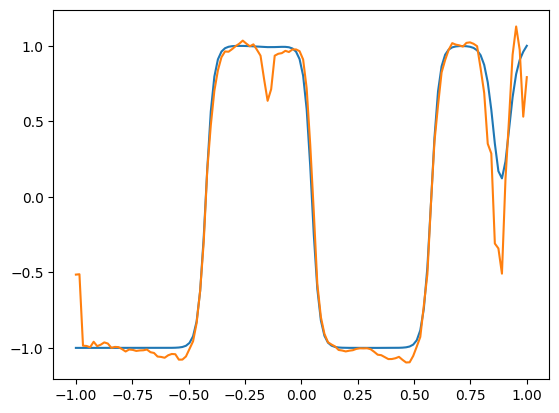

In [ ]:
hp=1802
example_sharp=input_ood[hp,:]
time_sharp=time_ood[hp]
eps_sharp=epsilons_ood[hp]
output_sharp=output_ood[hp,:]
print(eps_sharp)
print(time_sharp)
prediction_output=fno(example_sharp.unsqueeze(0),time_sharp,eps_sharp)
print(prediction_output.shape)
plt.plot(torch.linspace(-1,1,128),output_sharp)
plt.plot(torch.linspace(-1,1,128),prediction_output.squeeze().detach())

For sharper epsilons and same types of initial conditions, the model makes a mean error of 9.5. This may be due to the high sensitivity of the solution to small variation of epsilon, making it unable to generalize well

In [ ]:
exp_dat=np.load('exp_dataset.npy',allow_pickle=True)
ood_eps025=torch.from_numpy(exp_dat[0,:,:,:]) #3x200x5x128
ood_eps02=torch.from_numpy(exp_dat[1,:,:,:])
ood_eps01=torch.from_numpy(exp_dat[2,:,:,:])
input_exp=torch.zeros(6000,128)
output_exp=torch.zeros(6000,128)
time_exp=torch.zeros(6000)
epsilons_exp=torch.zeros(6000)

ind=0
for i,j in time_ind:  #x10
    for q in range(200):    #3x200
        input_exp[ind*200+q,:]=ood_eps025[q,i,:]
        output_exp[ind*200+q,:]=ood_eps025[q,j,:]
        time_exp[ind*200+q]=(j-i)/400
        epsilons_exp[ind*200+q]=0.1

        input_exp[(ind+1)*200+q,:]=ood_eps025[q,i,:]
        output_exp[(ind+1)*200+q,:]=ood_eps025[q,j,:]
        time_exp[(ind+1)*200+q]=(j-i)/400
        epsilons_exp[(ind+1)*200+q]=0.075

        input_exp[(ind+2)*200+q,:]=ood_eps01[q,i,:]
        output_exp[(ind+2)*200+q,:]=ood_eps01[q,j,:]
        time_exp[(ind+2)*200+q]=(j-i)/400
        epsilons_exp[(ind+2)*200+q]=0.04

    ind+=3
exp_dataset=DataLoader(TensorDataset(input_exp,output_exp,time_exp,epsilons_exp),batch_size=100)

with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(exp_dataset):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(exp_dataset)

test_relative_l2

46.321392039457955

Plotting an example:

tensor(0.0400)
tensor(0.0025)
torch.Size([1, 128, 1])


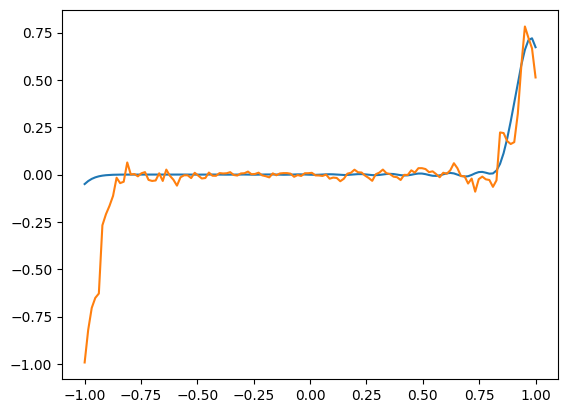

In [ ]:
id=503
example_exp=input_exp[id,:]
time_e=time_exp[id]
eps_e=epsilons_exp[id]
output_e=output_exp[id,:]
print(eps_e)
print(time_e)
prediction_output=fno(example_exp.unsqueeze(0),time_e,eps_e)
print(prediction_output.shape)
plt.plot(torch.linspace(-1,1,128),output_e)
plt.plot(torch.linspace(-1,1,128),prediction_output.squeeze().detach())

In [ ]:
exp_dat=np.load('high_freq_dataset.npy',allow_pickle=True)
ood_eps025=torch.from_numpy(exp_dat[0,:,:,:]) #3x200x5x128
ood_eps02=torch.from_numpy(exp_dat[1,:,:,:])
ood_eps01=torch.from_numpy(exp_dat[2,:,:,:])
ood_eps032=torch.from_numpy(exp_dat[3,:,:,:])
input_exp=torch.zeros(8000,128)
output_exp=torch.zeros(8000,128)
time_exp=torch.zeros(8000)
epsilons_exp=torch.zeros(8000)

ind=0
for i,j in time_ind:  #x10
    for q in range(200):    #3x200
        input_exp[ind*200+q,:]=ood_eps025[q,i,:]
        output_exp[ind*200+q,:]=ood_eps025[q,j,:]
        time_exp[ind*200+q]=(j-i)/400
        epsilons_exp[ind*200+q]=0.1

        input_exp[(ind+1)*200+q,:]=ood_eps025[q,i,:]
        output_exp[(ind+1)*200+q,:]=ood_eps025[q,j,:]
        time_exp[(ind+1)*200+q]=(j-i)/400
        epsilons_exp[(ind+1)*200+q]=0.075

        input_exp[(ind+2)*200+q,:]=ood_eps01[q,i,:]
        output_exp[(ind+2)*200+q,:]=ood_eps01[q,j,:]
        time_exp[(ind+2)*200+q]=(j-i)/400
        epsilons_exp[(ind+2)*200+q]=0.04

        input_exp[(ind+3)*200+q,:]=ood_eps01[q,i,:]
        output_exp[(ind+3)*200+q,:]=ood_eps01[q,j,:]
        time_exp[(ind+3)*200+q]=(j-i)/400
        epsilons_exp[(ind+3)*200+q]=0.032

    ind+=4
exp_dataset=DataLoader(TensorDataset(input_exp,output_exp,time_exp,epsilons_exp),batch_size=100)

with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input, output, time, eps) in enumerate(exp_dataset):
            output_pred = fno(input,time,eps).squeeze(2)
            loss_f = (torch.mean((output_pred - output) ** 2) / torch.mean(output ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(exp_dataset)

test_relative_l2

53.801584002375606

tensor(0.0050)
tensor(0.0400)


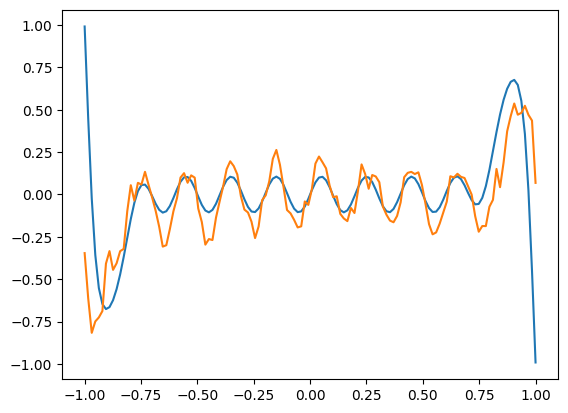

In [ ]:
idx=1239
example_exp=input_exp[idx,:]
time_e=time_exp[idx]
eps_e=epsilons_exp[idx]
output_e=output_exp[idx,:]
print(time_e)
print(eps_e)
prediction_output=fno(example_exp.unsqueeze(0),time_e,eps_e)

plt.plot(torch.linspace(-1,1,128),output_e)
plt.plot(torch.linspace(-1,1,128),prediction_output.squeeze().detach())

The model seems to not behave well for high frequency data: even sinusoidal waves aren't well represented by it